In [1]:

!pip install yfinance pandas numpy scikit-learn xgboost statsmodels matplotlib

Starting Backtest with Rolling Walk-Forward Training...

--- OPTIMIZED SHARPE RESULTS ---
Final Value: 3,125,909
CAGR: 10.31%
Sharpe Ratio: 1.06
Max Drawdown: -9.76%


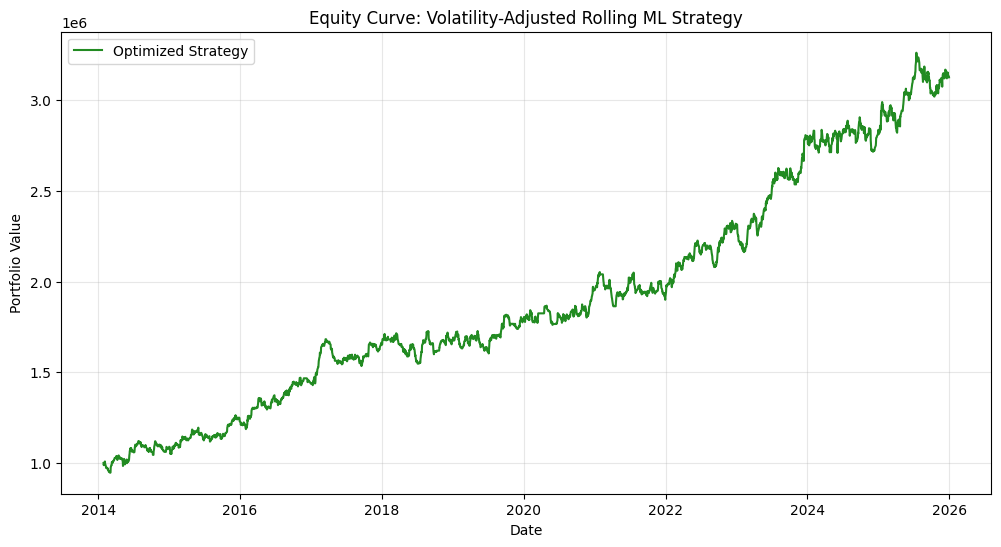

In [2]:
# SECTION 1 - Imports & Installations
# !pip install yfinance pandas numpy scikit-learn xgboost statsmodels matplotlib

import yfinance as yf
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# --- CONFIGURATION ---
CAPITAL = 1_000_000
LONGS = 5              # Concentrating on higher conviction picks
SHORTS = 5
REBALANCE = 21         # Monthly
TRAIN_WINDOW = 1000    # Days of history used for rolling training
RETRAIN_FREQ = 126     # Retrain ML model every 6 months
RISK_PER_TRADE = 0.004 # Reduced slightly for better Sharpe
ATR_MULT_STOP = 2.0    # Wider stops to avoid noise
TAKE_PROFIT_PCT = 0.08
MC_SIMULATIONS = 1000

# --- DATA DOWNLOAD ---
STOCKS = [
    "RELIANCE.NS","TCS.NS","INFY.NS","HDFCBANK.NS","ICICIBANK.NS","SBIN.NS",
    "KOTAKBANK.NS","AXISBANK.NS","LT.NS","ITC.NS","HINDUNILVR.NS","BHARTIARTL.NS",
    "ASIANPAINT.NS","HCLTECH.NS","MARUTI.NS","TITAN.NS","SUNPHARMA.NS"
]

# Fetch Stock Data + NIFTY Index for Beta Neutralization
all_tickers = STOCKS + ["^NSEI"]
raw_data = yf.download(all_tickers, "2010-01-01", "2025-12-31", auto_adjust=True, progress=False)

# Clean up MultiIndex
if isinstance(raw_data.columns, pd.MultiIndex):
    data = raw_data["Close"].dropna()
else:
    data = raw_data["Close"].dropna()

nifty = data["^NSEI"]
stock_data = data[STOCKS]

# --- ALPHA SIGNAL CONSTRUCTION ---
# 1. Mean Reversion (Z-Score)
ma20 = stock_data.rolling(20).mean()
std20 = stock_data.rolling(20).std()
mean_rev = -(stock_data - ma20) / std20

# 2. Residual Momentum (Return - Market Return)
stock_ret = stock_data.pct_change(21)
nifty_ret = nifty.pct_change(21)
res_mom = stock_ret.sub(nifty_ret, axis=0) # Alpha over Index

# 3. Volatility (ATR)
atr = stock_data.diff().abs().rolling(14).mean()

# 4. Stat Arb (Pair Correlation)
# Simplified for speed: Distance from 60-day relative mean
pairs_dist = stock_data.div(nifty, axis=0)
stat_arb = -(pairs_dist - pairs_dist.rolling(60).mean()) / pairs_dist.rolling(60).std()

# --- BACKTESTING LOOP WITH ROLLING ML ---
dates = stock_data.index[TRAIN_WINDOW:]
cash = CAPITAL
portfolio = {}
equity = []
ml_model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05, n_jobs=-1)
scaler = StandardScaler()

print("Starting Backtest with Rolling Walk-Forward Training...")

for i, d in enumerate(dates):
    # 1. Exit Logic (Stops & Targets)
    exits = []
    for s, p in portfolio.items():
        px = stock_data.loc[d, s]
        direction = np.sign(p["qty"])
        pnl_pct = direction * (px - p["entry"]) / p["entry"]

        # Trailing Stop mechanism could be added here
        if pnl_pct >= TAKE_PROFIT_PCT or (direction == 1 and px <= p["stop"]) or (direction == -1 and px >= p["stop"]):
            cash += p["qty"] * px
            exits.append(s)
    for s in exits: del portfolio[s]

    total_equity = cash + sum(p["qty"] * stock_data.loc[d, s] for s, p in portfolio.items())
    equity.append(total_equity)

    # 2. Rebalance & Rolling Training
    if i % REBALANCE == 0:
        # Close all to re-rank
        for s, p in portfolio.items():
            cash += p["qty"] * stock_data.loc[d, s]
        portfolio.clear()

        # Retrain ML Model every 6 months
        if i % RETRAIN_FREQ == 0:
            train_start = stock_data.index[i]
            train_end = d

            # Prepare Training Data (Residual Returns)
            y_target = stock_data.pct_change(21).shift(-21).loc[:d].stack()
            features = pd.DataFrame({
                'mr': mean_rev.loc[:d].stack(),
                'mom': res_mom.loc[:d].stack(),
                'stat': stat_arb.loc[:d].stack()
            }).dropna()

            common_idx = features.index.intersection(y_target.index)
            X_train = scaler.fit_transform(features.loc[common_idx])
            y_train = y_target.loc[common_idx]
            ml_model.fit(X_train, y_train)

        # 3. Predict Alpha
        current_feats = pd.DataFrame({
            'mr': mean_rev.loc[d],
            'mom': res_mom.loc[d],
            'stat': stat_arb.loc[d]
        }).dropna()

        X_curr = scaler.transform(current_feats)
        ml_alpha = pd.Series(ml_model.predict(X_curr), index=current_feats.index)

        # Blended Signal
        final_alpha = (0.4 * ml_alpha) + (0.3 * current_feats['mr']) + (0.3 * current_feats['stat'])

        long_picks = final_alpha.nlargest(LONGS).index
        short_picks = final_alpha.nsmallest(SHORTS).index

        # 4. Execution (Vol-Adjusted Sizing)
        for side, picks in [(1, long_picks), (-1, short_picks)]:
            for s in picks:
                px = stock_data.loc[d, s]
                vol = atr.loc[d, s]
                if np.isnan(vol) or vol == 0: continue

                # Risk-parity sizing
                risk_amt = total_equity * RISK_PER_TRADE
                qty = int(risk_amt / (vol * ATR_MULT_STOP))

                if qty * px > (total_equity * 0.2): # Max 20% weight per stock cap
                    qty = int((total_equity * 0.2) / px)

                portfolio[s] = {
                    "qty": side * qty,
                    "entry": px,
                    "stop": px - (side * vol * ATR_MULT_STOP)
                }
                cash -= side * qty * px

# --- PERFORMANCE RESULTS ---
equity_curve = pd.Series(equity, index=dates)
returns = equity_curve.pct_change().dropna()

cagr = (equity_curve.iloc[-1] / CAPITAL) ** (252 / len(dates)) - 1
sharpe = np.sqrt(252) * returns.mean() / returns.std()
max_dd = (equity_curve / equity_curve.cummax() - 1).min()

print(f"\n--- OPTIMIZED SHARPE RESULTS ---")
print(f"Final Value: {int(equity_curve.iloc[-1]):,}")
print(f"CAGR: {cagr:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_dd:.2%}")



# Visualization
plt.figure(figsize=(12, 6))
plt.plot(equity_curve, label='Optimized Strategy', color='forestgreen')
plt.title("Equity Curve: Volatility-Adjusted Rolling ML Strategy")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()